In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('/kaggle/input/airlines-delay/airlines_delay.csv')

In [3]:
df.set_index('Flight')

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
Flight,,,,,,,
2313.0,1296.0,141.0,DL,ATL,HOU,1,0
6948.0,360.0,146.0,OO,COS,ORD,4,0
1247.0,1170.0,143.0,B6,BOS,CLT,3,0
31.0,1410.0,344.0,US,OGG,PHX,6,0
563.0,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...
6973.0,530.0,72.0,OO,GEG,SEA,5,1
1264.0,560.0,115.0,WN,LAS,DEN,4,1
5209.0,827.0,74.0,EV,CAE,ATL,2,1


In [4]:
df['AirportTo']=LabelEncoder().fit_transform(df['AirportTo'])
df['AirportFrom']=LabelEncoder().fit_transform(df['AirportFrom'])
df['Airline']=LabelEncoder().fit_transform(df['Airline'])
df[['Time','Length']]=MinMaxScaler().fit_transform(df[['Time','Length']])

In [21]:
X = df.iloc[:35000,1:-1].values
y = df.iloc[:35000,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [30]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train,y_train)

log_pred = logistic_model.predict(X_test)
print("Accuracy Score : ", round(accuracy_score(y_test,log_pred)*100,2),'%')

Accuracy Score :  85.29 %


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [31]:
features = list(df.columns[1:-1])

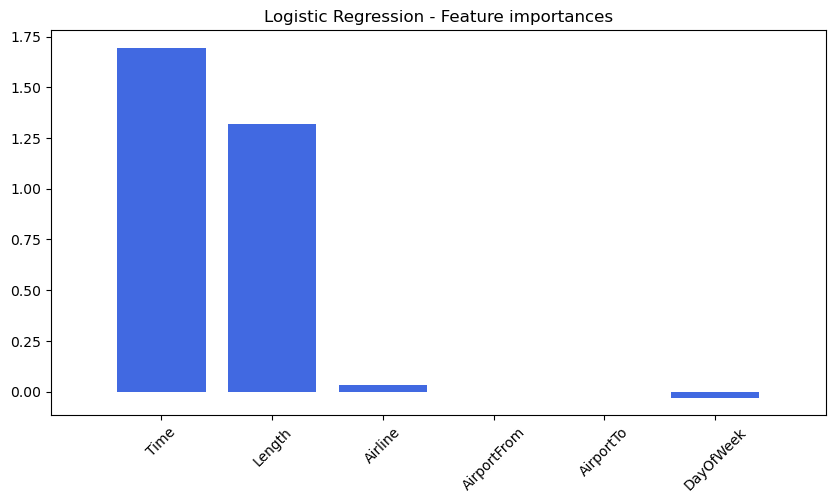

In [32]:
plt.figure(figsize=(10, 5))
plt.title("Logistic Regression - Feature importances")
plt.bar(range(len(features)), logistic_model.coef_[0], align="center", color="royalblue")
plt.xticks(range(len(features)), features, rotation=45)
plt.xlim([-1, len(features)])
plt.show()

In [33]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

log_pred = naive_bayes.predict(X_test)
print("Accuracy Score : ", round(accuracy_score(y_test, log_pred)*100, 2),'%')

Accuracy Score :  85.16 %


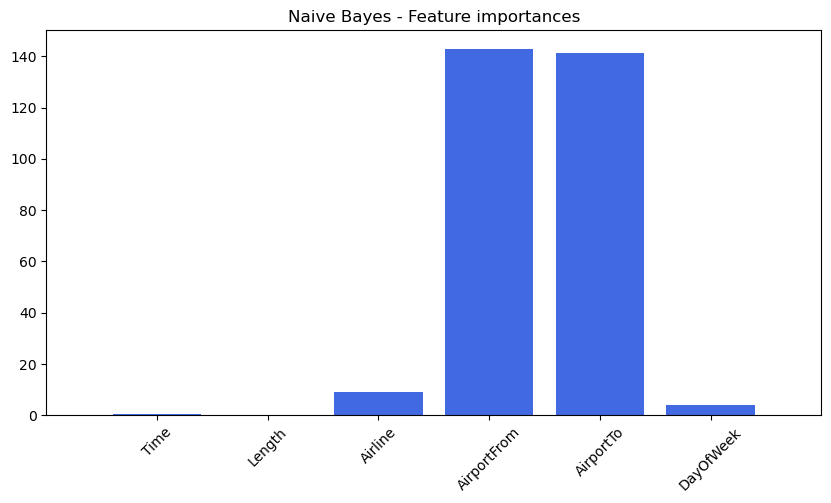

In [34]:
plt.figure(figsize=(10, 5))
plt.title("Naive Bayes - Feature importances")
plt.bar(range(len(features)), naive_bayes.theta_[0], align="center", color="royalblue")
plt.xticks(range(len(features)), features, rotation=45)
plt.xlim([-1, len(features)])
plt.show()

In [9]:
def SVM_train(overlap, kernel, samples, labels):
    model = SVC(C=overlap, gamma=1/(2*kernel**2))
    model.fit(samples, labels)
    return model


def SVM_test(model, test_samples, test_labels):
    predictions = model.predict(test_samples)
    error = (sum([predictions[i] != test_labels[i] for i in range(test_labels.shape[0])]) /
             test_labels.shape[0])
#     print('Test set has loss of ', error)
    return predictions, error

In [7]:
def k_fold_SVM(samples, labels, k=10):
    fig, ax = plt.subplots(figsize=(10, 8))
    overlaps = np.geomspace(0.01, 10, 4)
    kernels = np.geomspace(0.01, 10, 4)
    kf = KFold(n_splits=k, shuffle=True)

    min_error, min_error_overlap, min_error_kernel = np.Inf, -1, -1
    error_map = np.zeros((overlaps.shape[0], kernels.shape[0]))

    for i, overlap in enumerate(overlaps):
        for j, kernel in enumerate(kernels):
            errors = []
            N = len(labels)
            for train_indices, valid_indices in tqdm(kf.split(samples)):
                training_samples = samples[train_indices]
                training_labels = labels[train_indices]
                validation_samples = samples[valid_indices]
                validation_labels = labels[valid_indices]
                
                model = SVM_train(overlap, kernel, training_samples, training_labels)
                pred, error = SVM_test(model, validation_samples, validation_labels)
                errors.append(error)
            mean_error = np.mean(errors)
            error_map[i, j] = mean_error
            if mean_error < min_error:
                min_error = mean_error
                min_error_overlap = overlap
                min_error_kernel = kernel

    print('Overlap value of {} and kernel width of {} result in minimum error of {:.4f}'
          .format(min_error_overlap, min_error_kernel, min_error))

    ax.set_title('Mean error across k-validation for different hyperparameters')
    ax.imshow(error_map, interpolation='None', cmap="GnBu" )

    for i in range(len(overlaps)):
        for j in range(len(kernels)):
            text = 'Overlap: {}\nKernel Width: {}\nError: {:2f}'.format(overlaps[i], kernels[j], error_map[i, j])
            ax.text(j, i, text, va='center', ha='center')

    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

    return min_error_overlap, min_error_kernel

5it [04:31, 54.37s/it]
5it [04:08, 49.77s/it]
5it [02:29, 29.87s/it]
5it [00:51, 10.21s/it]
5it [06:45, 81.16s/it]
5it [05:57, 71.42s/it]
5it [04:24, 52.98s/it]
5it [01:53, 22.79s/it]
5it [08:41, 104.33s/it]
5it [07:01, 84.22s/it]
5it [05:38, 67.67s/it]
5it [03:33, 42.71s/it]
5it [11:06, 133.35s/it]
5it [08:23, 100.72s/it]
5it [07:00, 84.15s/it]
5it [04:43, 56.64s/it]


Overlap value of 0.01 and kernel width of 0.01 result in minimum error of 0.1450


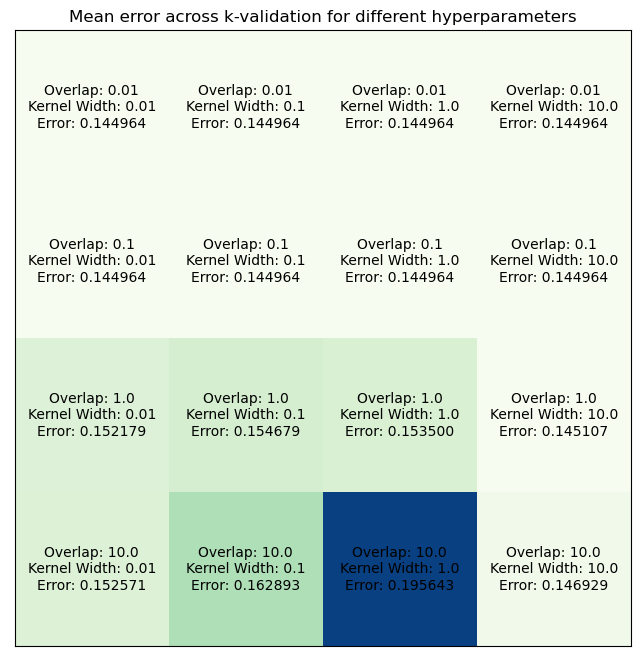

(0.01, 0.01)

In [26]:
k_fold_SVM(X_train, y_train, k=5)

In [27]:
SVM_model = SVM_train(0.01, 0.01, X_train, y_train)

In [28]:
SVM_pred, SVM_error = SVM_test(SVM_model, X_test, y_test)

In [29]:
SVM_error

0.14714285714285713